In [1]:
# Add submodule paths
import sys
sys.path += ['./normalizing_flows', './baselines', './climdex']

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import utils.data as data_util
import utils.nn_util as nn
import xarray as xr
import gcsfs
import dscnn
import climdex.temperature as tdex
import logging
from baselines.bcsd import BCSD
from normalizing_flows.models import VariationalModel, FlowLVM, JointFlowLVM, adversarial
from normalizing_flows.models.variational import nll_loss
from normalizing_flows.models.optimization import LinearWarmupSchedule
from normalizing_flows.flows import Transform, Flow, Invert
from normalizing_flows.flows.image import Upsample
from normalizing_flows.flows.glow import GlowFlow, coupling_nn_glow
from datasource import EraiRasDataLoader
from utils.preprocessing import remove_monthly_means
from utils.distributions import normal
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
#tf.autograph.set_verbosity(1)
#tf.config.experimental_run_functions_eagerly(True)
#tf.debugging.set_log_device_placement(True)

In [10]:
obj = np.load('/home/jovyan/generative-downscaling/mlruns/2/2ab3888b82dd41ef992c609307b74994/artifacts/data/metrics.npz', allow_pickle=True)

In [16]:
obj['txx_bias'].shape

(12, 32, 64, 1)

In [3]:
data = EraiRasDataLoader(gcs_bucket='erai-rasmussen', gcs_project='thesis-research-255223', auth='gcs.secret.json')
# era-interim
erai_deg1 = xr.open_zarr(data.erai('daily-1deg'), consolidated=True)
# 1-degree regridded rasmussen
ras_deg1 = xr.open_zarr(data.rasmussen('daily-1deg'), consolidated=True)
# 1/2-degree regridded rasmussen
ras_deg12 = xr.open_zarr(data.rasmussen('daily-1-2deg'), consolidated=True)
ras_deg14 = xr.open_zarr(data.rasmussen('daily-1-4deg'), consolidated=True)
ras_deg18 = xr.open_zarr(data.rasmussen('daily-1-8deg'), consolidated=True)
#ras_deg116 = xr.open_zarr(rasmussen('daily-1-16deg'), consolidated=True)
# regions
def southeast_us(dataset, scale_factor=1):
    lats, lons = dataset.lat, dataset.lon
    seus_lat_st = np.abs(lats - 30).argmin().values
    seus_lat_en = seus_lat_st + 8*scale_factor
    seus_lon_st = np.abs(lons - 260).argmin().values
    seus_lon_en = seus_lon_st + 16*scale_factor
    dataset_seus = dataset.isel(lat=slice(seus_lat_st, seus_lat_en),
                                lon=slice(seus_lon_st, seus_lon_en))
    return dataset_seus

erai_deg1_seus = southeast_us(erai_deg1)
ras_deg1_seus = southeast_us(ras_deg1)
ras_deg12_seus = southeast_us(ras_deg12, scale_factor=2)
ras_deg14_seus = southeast_us(ras_deg14, scale_factor=4)
ras_deg18_seus = southeast_us(ras_deg18, scale_factor=8)

In [4]:
split_fn = data_util.create_time_series_train_test_generator(n_splits=3)
def preprocess_maxt(ds):
    return ds[['MAXT']].fillna(0.).clip(min=0.0, max=np.inf)
ras_seus_maxt_14 = preprocess_maxt(ras_deg14_seus)
ras_seus_maxt_1 = preprocess_maxt(ras_deg1_seus)
erai_seus_maxt_1 = preprocess_maxt(erai_deg1_seus)
folds = list(split_fn(erai_seus_maxt_1, ras_seus_maxt_1, ras_seus_maxt_14))

In [5]:
def preprocess_vds(data_lo, data_hi, batch_size=100, buffer_size=1000, supervised=True):
    if supervised:
        data = tf.data.Dataset.zip((data_lo, data_hi)).shuffle(buffer_size)
    else:
        data = tf.data.Dataset.zip((data_lo.shuffle(buffer_size), data_hi.shuffle(buffer_size)))
    return data.batch(batch_size)

In [6]:
def plot_1xn(data):
    n = len(data)
    plt.figure(figsize=(n*9,6))
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(data[i].numpy().squeeze(), origin='lower')
        plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()

In [7]:
indices = tdex.indices('Time')
def eval_climdex(true, pred, coords):
    true_arr = xr.DataArray(true, coords=coords)
    pred_arr = xr.DataArray(pred, coords=coords)
    txx_true = indices.monthly_txx(true_arr)
    txx_pred = indices.monthly_txx(pred_arr)
    txn_true = indices.monthly_txn(true_arr)
    txn_pred = indices.monthly_txn(pred_arr)
    txx_bias = txx_pred - txx_true
    txn_bias = txn_pred - txn_true
    return txx_bias, txn_bias

### Bias-Correction Spatial Disaggregation (BCSD)

In [8]:
bcsd = BCSD(verbose=True)
#(lr_train, lr_obs_train, hr_train), (lr_test, lr_obs_test, hr_test) = folds[-1]
N = erai_seus_maxt_1.Time.size
lr_train = erai_seus_maxt_1.isel(Time=slice(0,N-365)).to_array(dim='chan').transpose('Time','lat','lon','chan')
lr_test = erai_seus_maxt_1.isel(Time=slice(N-365,N+1)).to_array(dim='chan').transpose('Time','lat','lon','chan')
lr_obs_train = ras_seus_maxt_1.isel(Time=slice(0,N-365)).to_array(dim='chan').transpose('Time','lat','lon','chan')
lr_obs_test = ras_seus_maxt_1.isel(Time=slice(N-365,N+1)).to_array(dim='chan').transpose('Time','lat','lon','chan')
hr_train = ras_seus_maxt_14.isel(Time=slice(0,N-365)).to_array(dim='chan').transpose('Time','lat','lon','chan')
hr_test = ras_seus_maxt_14.isel(Time=slice(N-365,N+1)).to_array(dim='chan').transpose('Time','lat','lon','chan')
# lr_train, monthly_means_lr = remove_monthly_means(lr_train)
# lr_obs_train, monthly_means_lr_obs = remove_monthly_means(lr_obs_train)
# hr_train, monthly_means_hr = remove_monthly_means(hr_train)
# lr_test,_ = remove_monthly_means(lr_test, monthly_means_lr)
# lr_obs_test,_ = remove_monthly_means(lr_obs_test, monthly_means_lr_obs)
# hr_test,_ = remove_monthly_means(hr_test, monthly_means_hr)
bcsd.fit(lr_train, hr_train, lr_obs_train)
hr_pred = bcsd.predict(lr_test).values

INFO:root:initializing tensors for low resolution datasets
INFO:root:fitting quantile map
INFO:root:computing scaling factors
INFO:root:applying bias-correction quantile mapping
INFO:root:interpolating low resolution data to target resolution


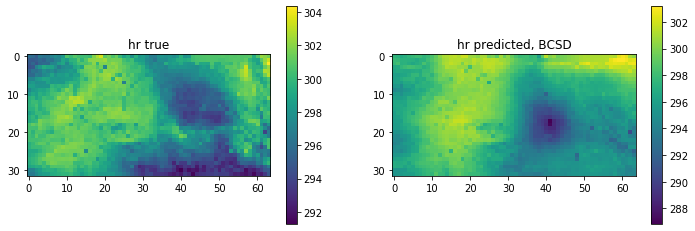

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(hr_test[0].squeeze())
plt.colorbar()
plt.title('hr true')
plt.subplot(1,2,2)
plt.imshow(hr_pred[0].squeeze())
plt.colorbar()
plt.title('hr predicted, BCSD')
plt.show()

In [10]:
_, means = remove_monthly_means(hr_train)
hr_test, _ = remove_monthly_means(hr_test, means)
hr_pred, _ = remove_monthly_means(xr.DataArray(hr_pred, coords=hr_test.coords, dims=hr_test.dims), means)
err = (hr_test - hr_pred)**2
print(np.sqrt(np.min(err)).values, np.sqrt(np.max(err)).values)
print(f'BCSD test rmse: {float(np.sqrt(np.mean(err)))} +/- {float(np.sqrt(np.std(err)))}')

5.6931621088551765e-06 19.984285152946086
BCSD test rmse: 2.3055165569030724 +/- 3.2489679599287693


In [11]:
np.max(hr_pred.values)

16.422486732148172

In [12]:
x = np.random.randn(10,10)

In [14]:
print(x.mean(), x.mean(axis=0).mean(axis=0))

0.11479822629833375 0.11479822629833374


### Baseline: Vanilla inference network for downscaling

$f: X \rightarrow \Theta$, $\hat{y} \sim p(\Theta)$

Fold 1/3
1200 training samples, 1200 test samples, 8x16 -> 32x64


test, epoch 5/5: 100%|██████████| 120/120 [00:13<00:00,  9.08it/s, nll=2.16]


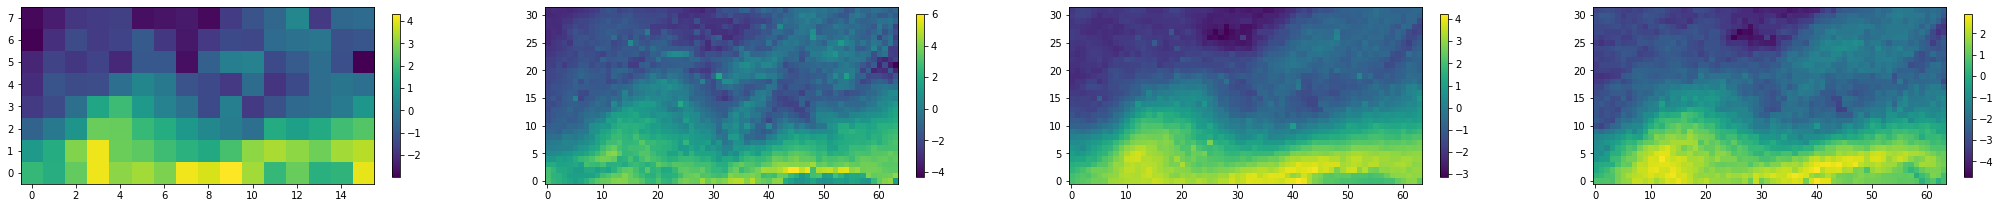

train, epoch 1/5:   0%|          | 0/240 [00:00<?, ?it/s]

Fold 2/3
2400 training samples, 2400 test samples, 8x16 -> 32x64


test, epoch 5/5: 100%|██████████| 240/240 [00:25<00:00,  9.24it/s, nll=1.93]


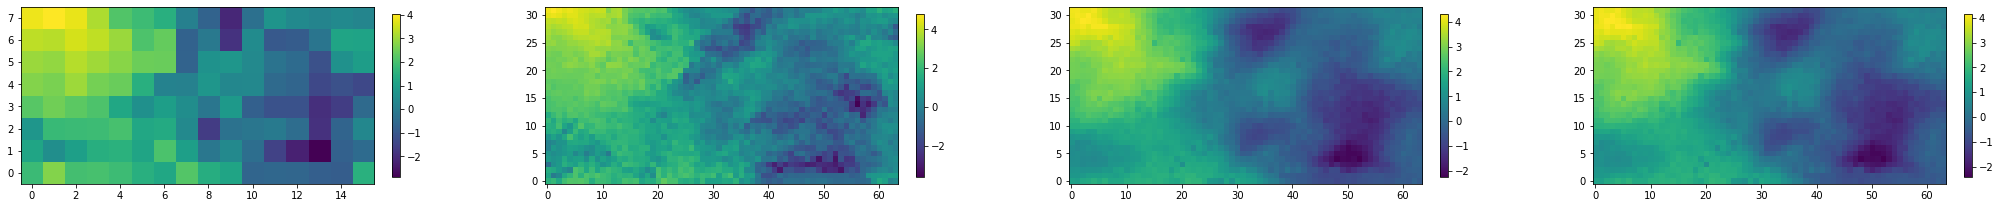

train, epoch 1/5:   0%|          | 0/360 [00:00<?, ?it/s]

Fold 3/3
3600 training samples, 3600 test samples, 8x16 -> 32x64


test, epoch 5/5: 100%|██████████| 360/360 [00:51<00:00,  6.96it/s, nll=1.84] 


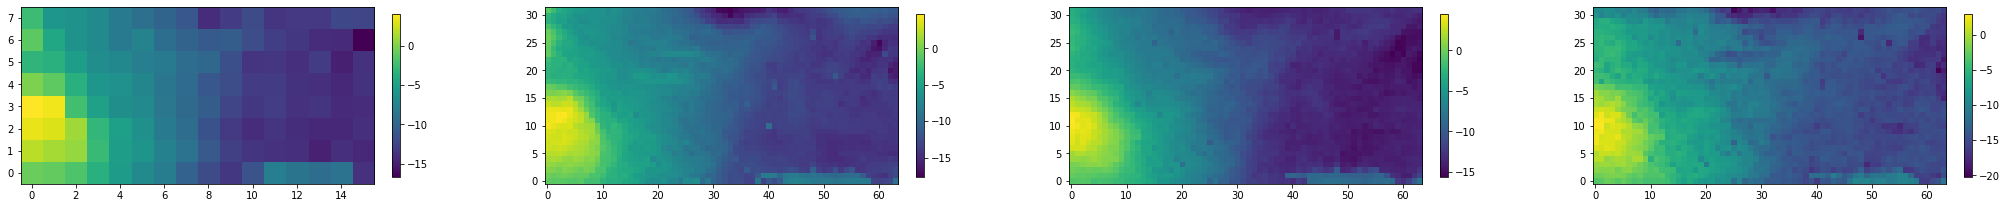

In [8]:
sample_batch_size = 10
load_batch_size = 1200
n_epochs = 5
def rmse(y_true, y_pred):
    return tf.math.sqrt(tf.math.reduce_mean((y_true - y_pred)**2, axis=[1,2,3]))
def bias(y_true, y_pred):
    return tf.math.reduce_mean(y_pred - y_true, axis=[1,2,3])
for i, ((train_lo, train_hi), (test_lo, test_hi)) in enumerate(folds):
    print(f'Fold {i+1}/{len(folds)}')
    N_train, N_test = train_lo.Time.size, train_lo.Time.size
    (wt, ht), (wt_hi, ht_hi) = train_lo.shape[1:3], train_hi.shape[1:3]
    print('{} training samples, {} test samples, {}x{} -> {}x{}'.format(N_train, N_test, wt, ht, wt_hi, ht_hi))
    #batch_multiplier = data_util.calculate_n_subimages(train_lo, k, stride)
    train_steps = data_util.num_batches(N_train, sample_batch_size)
    test_steps = data_util.num_batches(N_test, sample_batch_size)
    train_lo_ds = data_util.xr_to_tf_dataset(train_lo, load_batch_size)
    test_lo_ds = data_util.xr_to_tf_dataset(test_lo, load_batch_size)
    train_hi_ds = data_util.xr_to_tf_dataset(train_hi, load_batch_size)
    test_hi_ds = data_util.xr_to_tf_dataset(test_hi, load_batch_size)
    train_ds = preprocess_vds(train_lo_ds, train_hi_ds, batch_size=sample_batch_size)
    test_ds = preprocess_vds(test_lo_ds, test_hi_ds, batch_size=sample_batch_size)
    #vdsrcnn = dscnn.create_vdsrcnn(scale=wt_hi // wt, c_in=1, c_out=2, module_layers=2, n_layers=5, output_init='zeros')
    encoder = dscnn.create_bmg_cnn10(wt, ht, scale=wt_hi // wt, c_out=2)
    model = VariationalModel(encoder, normal())
    model.compile(optimizer=Adamax(lr=1.0E-3), output_shape=(None,wt_hi,ht_hi,1))
    model.fit(train_ds.repeat(n_epochs), epochs=n_epochs, steps_per_epoch=train_steps,
              validation_data=test_ds.repeat(n_epochs), validation_steps=test_steps)
    test_x, test_y = next(test_ds.__iter__())
    pred = model.predict_mean(test_x)
    sample = model.sample(test_x, sample_fn=lambda d: d.loc + d.scale*tf.random.normal((sample_batch_size,1,1,1)))
    plt.figure(figsize=(4*9,6))
    plt.subplot(1,4,1)
    plt.imshow(test_x.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,2)
    plt.imshow(test_y.numpy()[0].squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,3)
    plt.imshow(pred[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.subplot(1,4,4)
    plt.imshow(sample[0].numpy().squeeze(), origin='lower')
    plt.colorbar(pad=0.04, shrink=0.5)
    plt.show()